# Solving a 2nd-order PDE BVP with a neural network

## Setup

In [2]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [3]:
from math import exp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Introduction

This notebook will demonstrate how to use the code in the `nnpde2bvp.py` module. The module allows the user to solve 2nd-order partial differential equation (PDE) boundary value problems (BVPs) with two variables, and Dirichlet boundary conditions, using a single-hidden layer neural network.

This work is based on the paper ["Artificial Neural Networks for Solving Ordinary and Partial Differential Equations", by Lagaris et al, *IEEE Transactions on Neural Networks, Volume 9, No. 5*, September 1998](http://ieeexplore.ieee.org/document/712178/). Note that the notation used in this notebook and the associated Python code differs slightly from that used in the Lagaris paper.

## The algorithm

Consider an $m$-dimensional space containing vectors $\vec x = (x_1,x_2,...,x_m)$. Any 2nd-order PDE for the scalar function $\psi(\vec x)$ can be written in the form:

\begin{equation}
G \left ( \vec x,\psi,\vec \nabla \psi,\nabla^2 \psi \right ) = 0
\end{equation}

The problem is to find a solution $\psi (\vec x)$ to the PDE using a neural network, subject to the boundary conditions:

\begin{equation}
\psi(0,x_2,x_3,...)=A_1(\vec x)
\end{equation}

\begin{equation}
\psi(1,x_2,x_3,...)=B_1(\vec x), etc.
\end{equation}

The network is trained using a set of $n$ training points $\vec x_i$ ($1 \leq i \leq n$), defined over the domain of interest. This work assumes that the vectors $\vec x_i$ have been scaled so that each component $x_{ij} \in [0,1]$, $1 \leq j \leq m$. The training points need not be evenly-spaced. Note that only the independent variable vectors $\vec x_i$  of the training points are needed - the estimated value of the solution at the training points is obtained using a trial solution $\psi_t$ of the form:

\begin{equation}
\psi_t(\vec x_i,\vec p) = A(\vec x_i) + P(\vec x_i) N(\vec x_i,\vec p)
\end{equation}

or:

\begin{equation}
\psi_{ti} = A_i + P_i N_i
\end{equation}

where $\psi_{ti}$ is the value of the trial solution at the current training point $\vec x_i$, $A_i$ is a function which yields the initial conditions at the origin of each dimension, $P_i$ is a function which vanishes at the origin of each dimension, and $N_i$ is the floating-point single-valued output from an unspecified neural network with network parameters $\vec p$. Note that this trial solution satisfies the boundary conditions by construction - wherever any coordinate is 0 or 1 (see below), the second term vanishes, leaving $\psi_t(\vec x_i, \vec p_i)=A(\vec x_i)$, which is just the specified boundary condition for that coordinate. The PDE is assumed to have been preprocessed so that all boundary conditions lie at the origin and at $1$. For a 2-variable PDE with independent variables $x$ and $y$, this condition is represented by:

\begin{equation}
\psi_t(0,y,\vec p) = f_0(y)
\end{equation}

\begin{equation}
\psi_t \left ( 1,y,\vec p \right ) = f_1(y)
\end{equation}

\begin{equation}
\psi_t(x,0,\vec p) = g_0(x)
\end{equation}

\begin{equation}
\psi_t \left ( x,1,\vec p \right ) = g_1(x)
\end{equation}

The analytical forms of $A(\vec x_i)$ and $P(\vec x_i)$ are constructed to meet these requirements, and noting that, by continuity at the corners of the domain, $f_0(0)=g_0(0)$, etc.. For a 2-variable PDE, we have:

\begin{equation}
A(x,y) = (1-x)f_0(y) + x f_1(y) +
(1-y)(g_0(x) - (1-x)g_0(0) - x g_0(1)) +
y(g_1(x) - (1 - x)g_1(0) - x g_1(1))
\end{equation}

\begin{equation}
P(x,y) = x(1 - x)y(1 - y)
\end{equation}

These functions rapidly become more complex as the number of problem dimensions is increased, so this example will utilize a 2-variable PDE. Training is done in a set of *epochs*. A training epoch consists of presenting the neural network with each of the $n$ training points $\vec x_i$, one at a time. For each input point $\vec x_i$, the network output $N_i$ is computed. Once all $n$ points have been presented, the epoch is complete, and the error function $E$ is computed. The problem definition provides an analytical form for the error function, as the sum of squared errors (SSE) for each of the training points:

\begin{equation}
E = \sum_{i=1}^{n} \left( G(\vec x_i,\psi_{ti}, \vec \nabla \psi_{ti}), \nabla^2 \psi_{ti} \right)^2 =
\sum_{i=1}^{n} G_i^2
\end{equation}

Once this error function is computed, the parameters in the neural network are adjusted to reduce the error. Eventually, a minimum of $E$ is attained, and the resulting final form of $\psi_t(x)$ is used as the solution to the original PDE.

## Computing the network output $N_i$

The neural network used in this work has a simple structure. One input node for each component of $\vec x_i$ is used (for a total of $m$ input nodes) to provide the training data. Each input node is fully-connected to each of a set of $H$ hidden nodes, each using a sigmoid transfer function. Each hidden node is connected to the single output node, which uses a linear transfer function with a weight for the signal from each hidden node.

During each step of a training epoch, the input to the network is just the training point $\vec x_i$. Each input node $j$ receives one component $x_{ij}$, and emits that value as output. These outputs are sent to each of the $H$ hidden nodes. At each hidden node $k$, the input values $x_{ij}$ are combined and scaled by the equation:

\begin{equation}
z_{ik} = \sum_{j=1}^m w_{jk} x_{ij} + u_k
\end{equation}

where  $w_{jk}$ is the weight for input node $j$ at hidden node $k$, and $u_k$ is the bias at hidden node $k$. This combined value is then used as the input to a sigmoidal transfer function:

\begin{equation}
\sigma_{ik} = \sigma(z_{ik})
\end{equation}

where:

\begin{equation}
\sigma(z) = \frac {1}{1+e^{-z}}
\end{equation}

A plot of this transfer function and its first three derivatives is provided below.

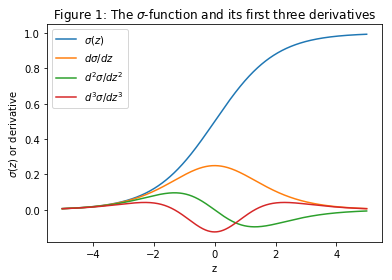

In [4]:
def sigma(z):
    return 1 / (1 + exp(-z))

def dsigma_dz(z):
    return exp(-z) / (1 + exp(-z))**2

def d2sigma_dz2(z):
    return (
        2 * exp(-2 * z) / (1 + exp(-z))**3 - exp(-z) / (1 + exp(-z))**2
    )

def d3sigma_dz3(z):
    return (
        6 * exp(-3 * z) / (1 + exp(-z))**4
        - 6 * exp(-2 * z) / (1 + exp(-z))**3
        + exp(-z) / (1 + exp(-z))**2
    )

z = np.arange(-5, 5, 0.01)
n = len(z)
s = np.zeros(n)
ds_dz = np.zeros(n)
d2s_dz2 = np.zeros(n)
d3s_dz3 = np.zeros(n)
for i in range(n):
    s[i] = sigma(z[i])
    ds_dz[i] = dsigma_dz(z[i])
    d2s_dz2[i] = d2sigma_dz2(z[i])
    d3s_dz3[i] = d3sigma_dz3(z[i])
plt.plot(z,s,label = "$\sigma(z)$")
plt.plot(z,ds_dz,label = "$d\sigma/dz$")
plt.plot(z,d2s_dz2, label = "$d^2\sigma/dz^2$")
plt.plot(z,d3s_dz3, label = "$d^3\sigma/dz^3$");
plt.xlabel("z")
plt.ylabel("$\sigma(z)$ or derivative")
plt.title("Figure 1: The $\sigma$-function and its first three derivatives")
plt.legend();

Once the $\sigma_{ik}$ are computed, they are all passed to the single output node, where they are processed by a linear transfer function to create the network output for the current input point $\vec x_i$:

\begin{equation}
N_i = \sum_{k=1}^{H}v_k\sigma_{ik}
\end{equation}

where $v_k$ is the weight applied to the signal from hidden node $k$ at the output node. Once $N_i$ has been computed, the trial function $\psi_{ti}$ is computed, along with its partial derivatives, and then the value of the PDE $G_i$is computed, and finally the error function $E$.

## Updating the network parameters

The network parameters are the weights and biases of the hidden and output nodes. For an $m$-dimensional input point $\vec x_i$, and a set of $H$ hidden nodes, we have a total of $N_p = (m+2)H$ parameters in total: a weight for each $x_{ij}$ for each hidden node, a bias for each hidden node, and an output weight for each hidden node.

Since the objective function to minimize is the error $E$, the value of each network parameter $p$ (where $p$ represents $v_k$, $u_k$, or $w_{jk}$) is updated using a scaled, simplified Newton's method:

\begin{equation}
p_{new}=p - \eta \frac {\partial E} {\partial p}
\end{equation}

where $\eta$ is the *learning rate* (usually $\eta < 1$). This simplified method (ignoring the usual 2nd derivative in the denominator of the correction term) is appropriate when the problem is scaled to the domain $[0,1]$. The learning rate is used to reduce the chance of solution instability due to large values of the correction term. The derivatives of $E$ are computed using the known form of the network and internal parameters.

This process of parameter updates is repeated until convergence is achieved (an error minimum is reached), or until the specified maximum number of training epochs have been applied. Note that the same set of training points is presented during each epoch.

## Computing the derivatives of $E$

The partial derivatives of $E$ with respect to any network parameter $p$ are given by:

\begin{equation}
\frac {\partial E}{\partial p} =
2 \sum_{i=1}^n G_i \frac {\partial G_i}{\partial p}
\end{equation}

## Computing the derivatives of $G_i$

The partial derivative of $G_i$ with respect to any network parameter $p$ is computed using the chain rule:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial}{\partial p} G_i\left(
\vec x_i, \psi_{ti}, \vec \nabla \psi _{ti}, \nabla^2 \psi_{ti}
\right) =
\sum_{j=1}^m \frac {\partial \psi_{ti}}{\partial x_{ij}} \frac {\partial x_{ij}}{\partial p} +
\frac {\partial G_i}{\partial \psi_{ti}} \frac {\partial \psi_{ti}}{\partial p} +
\sum_{j=1}^m \frac {\partial G_i}{\partial \frac {\partial \psi_{ti}}{\partial x_{ij}}} \frac {\partial^2 \psi_{ti}}{\partial p \partial x_{ij}} +
\sum_{j=1}^m \frac {\partial G_i}{\partial \frac {\partial^2 \psi_{ti}}{\partial x_{ij}^2}} \frac {\partial^3 \psi_{ti}}{\partial p \partial x_{ij}^2}
\end{equation}

Since the training points $x_i$ are independent of the network parameters $\vec p$, this equation simplifies to:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial G_i}{\partial \psi_{ti}} \frac {\partial \psi_{ti}}{\partial p} +
\sum_{j=1}^m \frac {\partial G_i}{\partial \frac {\partial \psi_{ti}}{\partial x_{ij}}} \frac {\partial^2 \psi_{ti}}{\partial p \partial x_{ij}} +
\sum_{j=1}^m \frac {\partial G_i}{\partial \frac {\partial^2 \psi_{ti}}{\partial x_{ij}^2}} \frac {\partial^3 \psi_{ti}}{\partial p \partial x_{ij}^2}
\end{equation}

Note that the partials of $G_i$ by $\psi$, $\vec \nabla \psi$, and $\nabla^2 \psi$ must be supplied in anaytical form, since the analytical form of $G_i(\vec x,\psi,\vec \nabla \psi, \nabla^2 \psi_{ti})$ is known.

## Computing the derivatives of $\psi_{ti}$

The generic form of the first derivative of $\psi_{ti}$ is:

\begin{equation}
\frac {\partial \psi_{ti}}{\partial x_{ij}} =
\frac {\partial A_i}{\partial x_{ij}} + P_i \frac {\partial N_i}{\partial x_{ij}} + \frac {\partial P_i}{\partial x_{ij}} N_i
\end{equation}

The cross-partials are:

\begin{equation}
\frac {\partial^2 \psi_{ti}} {\partial p \partial x_{ij}} = \
P_i \frac {\partial^2 N_i} {\partial p \partial x_{ij}} + \
\frac {\partial P_i} {\partial x_{ij}} \frac {\partial N_i} {\partial p}
\end{equation}

The generic form of the second derivative of $\psi_{ti}$ is:

\begin{equation}
\frac {\partial^2 \psi_{ti}}{\partial x_{ij}^2} =
\frac {\partial^2 A_i}{\partial x_{ij}^2} +
P_i \frac {\partial^2 N_i}{\partial x_{ij}^2} +
2 \frac {\partial P_i}{\partial x_{ij}} \frac {\partial N_i}{\partial x_{ij}} +
\frac {\partial^2 P_i}{\partial x_{ij}^2} N_i
\end{equation}

The cross-partials are:

\begin{equation}
\frac {\partial^3 \psi_{ti}}{\partial p \partial x_{ij}^2} =
P_i \frac {\partial^3 N_i}{\partial p \partial x_{ij}^2} +
2 \frac {\partial P_i}{\partial x_{ij}} \frac {\partial^2 N_i}{\partial p \partial x_{ij}} +
\frac {\partial^2 P_i}{\partial x_{ij}^2} \frac {\partial N_i}{\partial p}
\end{equation}

## Computing the derivatives of $N_i$

\begin{equation}
\frac {\partial^2 \psi_{ti}} {\partial p \partial x_{ij}} = \
P_i \frac {\partial^2 N_i} {\partial p \partial x_{ij}} + \
\frac {\partial P_i} {\partial x_{ij}} \frac {\partial N_i} {\partial p}
\end{equation}

The generic form of the first derivative of $N_i$ with respect to $x_{ij}$ is:

\begin{equation}
\frac {\partial N_i}{\partial x_{ij}} =
\frac {\partial}{\partial x_{ij}} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial x_{ij}} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial z_{ik}} \frac {\partial z_{ik}}{\partial x_{ij}} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial x_{ij}} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_{jk}
\end{equation}

where the transfer function derivatives are defined by:

\begin{equation}
\sigma^{(n)} = \frac {\partial^n \sigma}{\partial z^n}
\end{equation}

For the parameter derivatives:

\begin{equation}
\frac {\partial N_i}{\partial p} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H \left ( v_k \frac {\partial \sigma_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right )
\end{equation}

For the cross-partials:

\begin{equation}
\frac {\partial^2 N_i}{\partial p \partial x_{ij}} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_{jk} =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_{jk}}{\partial p} +
v_k \frac {\partial \sigma_{ik}^{(1)}}{\partial p}  w_{jk} +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_{jk} \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_{jk}}{\partial p} +
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}}{\partial p}  w_{jk} +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_{jk} \right )
\end{equation}

## Computing the derivatives of $z_{ik}$

The derivatives of $z_{ik}$ with respect to the network parameter $p$ are parameter-specific:

\begin{equation}
\frac {\partial z_{il}}{\partial v_k} = 0
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial u_k} = \delta_{kl}
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial w_{jk}} = x_{ij} \delta_{kl}
\end{equation}

## Computing the derivatives of the parameters $\vec p$

At this lowest level, the parameter derivatives are simple in form:

\begin{equation}
\frac {\partial v_l}{\partial v_k} = \delta_{kl}, \frac {\partial v_l}{\partial u_k} = 0, \frac {\partial v_l}{\partial w_{jk}} = 0
\end{equation}

\begin{equation}
\frac {\partial u_l}{\partial v_k} = 0, \frac {\partial u_l}{\partial u_k} = \delta_{kl}, \frac {\partial u_l}{\partial w_{jk}} = 0
\end{equation}

\begin{equation}
\frac {\partial w_{hl}}{\partial v_k} = 0, \frac {\partial w_{hl}}{\partial u_k} = 0, \frac {\partial w_{hl}}{\partial w_{jk}} = \delta_{hj} \delta_{kl}
\end{equation}

# Walking through an example problem

Consider the simple 1st-order partial differential equation:

\begin{equation}
G \left ( \vec x, \psi, \vec \nabla \psi, \nabla^2 \psi \right ) = xy - \psi = 0
\end{equation}

In Python form:

In [5]:
def Gf(xy, psi, del_psi, del2_psi):
    (x, y) = xy
    return x * y - psi

The analytical solution to this PDE is:

\begin{equation}
\psi(x,y) = xy
\end{equation}

This function is plotted in the following figure:

/Users/ewinter/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


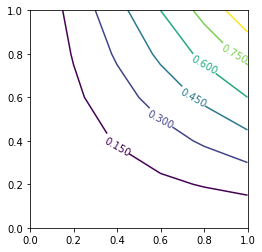

In [6]:
x = np.linspace(0,1,6)
y = np.linspace(0,1,6)
x,y = np.meshgrid(x,y)
z = x*y
plt.figure()
cplot = plt.contour(x,y,z)
plt.clabel(cplot, inline=1, fontsize=10)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axes().set_aspect('equal');

We need to specify quite a few derivatives, but most of them vanish. To begin, the first partials of $G(\vec x,\psi,\vec \nabla \psi, \nabla^2 \psi)$:

\begin{equation}
\frac {\partial G} {\partial x} = y
\end{equation}

\begin{equation}
\frac {\partial G} {\partial y} = x
\end{equation}

In Python form, these equations are (unused arguments are ignored):

In [7]:
def dG_dxf(xy,psi,del_psi,del2_psi):
    (x,y) = xy
    return y

In [8]:
def dG_dyf(xy, psi, del_psi, del2_psi):
    (x, y) = xy
    return x

In [9]:
del_Gf = (dG_dxf,dG_dyf)

\begin{equation}
\frac {\partial G} {\partial \psi} = -1
\end{equation}

In Python form:

In [10]:
def dG_dpsif(xy, psi, del_psi, del2_psi):
    return -1

\begin{equation}
\frac {\partial G} {\partial \left ( \frac {\partial \psi} {\partial x} \right )} = 0
\end{equation}

\begin{equation}
\frac {\partial G} {\partial \left ( \frac {\partial \psi} {\partial y} \right )} = 0
\end{equation}

In Python form:

In [11]:
def dG_dpsi_dxf(xy, psi, del_psi, del2_psi):
    return 0

In [12]:
def dG_dpsi_dyf(xy, psi, del_psi, del2_psi):
    return 0

In [13]:
dG_ddel_psif = (dG_dpsi_dxf,dG_dpsi_dyf)

\begin{equation}
\frac {\partial G} {\partial \left ( \frac {\partial^2 \psi} {\partial x^2} \right )} = 0
\end{equation}

\begin{equation}
\frac {\partial G} {\partial \left ( \frac {\partial^2 \psi} {\partial y^2} \right )} = 0
\end{equation}

In Python form:

In [14]:
def dG_d2psi_dx2f(xy, psi, del_psi, del2_psi):
    return 0

In [15]:
def dG_d2psi_dy2f(xy, psi, del_psi, del2_psi):
    return 0

In [16]:
dG_ddel2_psif = (dG_d2psi_dx2f,dG_d2psi_dy2f)

The boundary condition functions and their required derivatives are:

\begin{equation}
f_0(y)=0
\end{equation}

\begin{equation}
f_1(y) = y
\end{equation}

\begin{equation}
g_0(x) = 0
\end{equation}

\begin{equation}
g_1(x) = x
\end{equation}

In Python form:

In [17]:
def f0f(y):
    return 0

In [18]:
def f1f(y):
    return y

In [19]:
def g0f(x):
    return 0

In [20]:
def g1f(x):
    return x

In [21]:
bcf = ((f0f, g0f), (f1f, g1f))

\begin{equation}
\frac {\partial f_0}{\partial y} = 0
\end{equation}

\begin{equation}
\frac {\partial f_1} {\partial y} = 1
\end{equation}

\begin{equation}
\frac {\partial g_0}{\partial x} = 0
\end{equation}

\begin{equation}
\frac {\partial g_1} {\partial x} = 1
\end{equation}

In [22]:
def df0_dyf(y):
    return 0

In [23]:
def df1_dyf(y):
    return 1

In [24]:
def dg0_dxf(x):
    return 0

In [25]:
def dg1_dxf(x):
    return 1

In [26]:
bcdf = ((df0_dyf, dg0_dxf), (df1_dyf, dg1_dxf))

\begin{equation}
\frac {\partial^2 f_0}{\partial y^2} = 0
\end{equation}

\begin{equation}
\frac {\partial^2 f_1} {\partial y^2} = 0
\end{equation}

\begin{equation}
\frac {\partial^2 g_0}{\partial x^2} = 0
\end{equation}

\begin{equation}
\frac {\partial^2 g_1} {\partial x^2} = 1
\end{equation}

In [27]:
def d2f0_dy2f(y):
    return 0

In [28]:
def d2f1_dy2f(y):
    return 0

In [29]:
def d2g0_dx2f(x):
    return 0

In [30]:
def d2g1_dx2f(x):
    return 0

In [31]:
bcd2f = ((d2f0_dy2f, d2g0_dx2f), (d2f1_dy2f, d2g1_dx2f))

Now that we have the forms for all of these derivatives and boundary conditions, we can create the training points. Use an evenly-spaced grid of 36 points.

In [49]:
nxy = 6
dxy = 1/(nxy - 1)
xt = np.zeros((nxy**2, 2))
for j in range(nxy):
    for i in range(nxy):
        k = j * nxy + i
        xt[k][0] = i * dxy
        xt[k][1] = j * dxy

Call the function which solves the ODE. Use 10 nodes in the hidden layer, and 1000 training epochs, a learning rate of 0.01, and activate verbose output.

In [50]:
np.random.seed(0)
from nnpde2bvp import nnpde2bvp
(psit,del_psit,del2_psit) = nnpde2bvp(
        Gf,             # 2-variable, 1st-order PDE IVP to solve
        dG_dpsif,       # Partial of G wrt psi
        dG_ddel_psif,   # Partials of G wrt del psi
        dG_ddel2_psif,   # Partials of G wrt del psi
        bcf,            # BC functions
        bcdf,           # BC function derivatives
        bcd2f,           # BC function 2nd derivatives
        xt,              # Training points as pairs
        nhid = 10,      # Node count in hidden layer
        maxepochs = 1000, # Max training epochs
        eta = 0.01,     # Learning rate
        debug = False,
        verbose = True
    )

0 0.0282496846572833
1 0.028189509816536402
2 0.028129466139621646
3 0.02806955332659885
4 0.028009771078302974
5 0.02795011909634167
6 0.027890597083092765
7 0.0278312047417018
8 0.02777194177607955
9 0.027712807890899586
10 0.027653802791595822
11 0.02759492618436005
12 0.027536177776139564
13 0.02747755727463471
14 0.02741906438829648
15 0.027360698826324154
16 0.027302460298662873
17 0.027244348516001278
18 0.027186363189769178
19 0.027128504032135122
20 0.027070770756004135
21 0.027013163075015324
22 0.026955680703539615
23 0.026898323356677346
24 0.02684109075025606
25 0.026783982600828145
26 0.026726998625668574
27 0.026670138542772615
28 0.026613402070853574
29 0.02655678892934055
30 0.026500298838376155
31 0.02644393151881429
32 0.026387686692217933
33 0.026331564080856885
34 0.026275563407705604
35 0.026219684396440936
36 0.026163926771440003
37 0.02610829025777797
38 0.02605277458122586
39 0.025997379468248424
40 0.025942104646001975
41 0.02588694984233223
42 0.0258319147857

338 0.01380934468799987
339 0.013780324186459804
340 0.013751365870054785
341 0.013722469605199517
342 0.013693635258610847
343 0.013664862697307056
344 0.0136361517886071
345 0.01360750240012988
346 0.013578914399793472
347 0.013550387655814436
348 0.013521922036707042
349 0.013493517411282593
350 0.01346517364864865
351 0.013436890618208316
352 0.01340866818965951
353 0.013380506232994274
354 0.013352404618498003
355 0.01332436321674879
356 0.013296381898616655
357 0.013268460535262852
358 0.01324059899813916
359 0.013212797158987155
360 0.01318505488983758
361 0.013157372063009511
362 0.013129748551109762
363 0.013102184227032134
364 0.013074678963956718
365 0.013047232635349232
366 0.013019845114960283
367 0.012992516276824696
368 0.012965245995260815
369 0.012938034144869845
370 0.012910880600535125
371 0.012883785237421435
372 0.012856747930974384
373 0.012829768556919646
374 0.012802846991262317
375 0.012775983110286285
376 0.012749176790553452
377 0.012722427908903136
378 0.012

670 0.006913272434714866
671 0.006899073874051892
672 0.0068849061368769695
673 0.006870769159227278
674 0.0068566628772801326
675 0.006842587227352662
676 0.0068285421459015295
677 0.00681452756952261
678 0.006800543434950676
679 0.006786589679059063
680 0.006772666238859426
681 0.00675877305150139
682 0.006744910054272238
683 0.006731077184596631
684 0.006717274380036282
685 0.006703501578289672
686 0.006689758717191729
687 0.006676045734713534
688 0.00666236256896202
689 0.0066487091581796595
690 0.006635085440744194
691 0.006621491355168297
692 0.006607926840099297
693 0.006594391834318871
694 0.006580886276742752
695 0.006567410106420429
696 0.006553963262534858
697 0.006540545684402152
698 0.006527157311471291
699 0.00651379808332383
700 0.006500467939673614
701 0.0064871668203664865
702 0.00647389466537995
703 0.0064606514148229655
704 0.006447437008935556
705 0.006434251388088591
706 0.006421094492783481
707 0.006407966263651871
708 0.0063948666414553644
709 0.00638179556708523

Plot the results of this training run.

/Users/ewinter/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


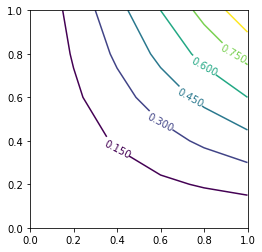

In [43]:
x = np.linspace(0,1,6)
y = np.linspace(0,1,6)
x,y = np.meshgrid(x,y)
z = psit.reshape(x.shape)
plt.figure()
cplot = plt.contour(x,y,z)
plt.clabel(cplot, inline=1, fontsize=10)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axes().set_aspect('equal');

Compare the computed values with the analytical values.

In [34]:
def psiaf(xy):
    (x, y) = xy
    return x * y

In [35]:
def dpsia_dxf(xy):
    (x, y) = xy
    return y

In [36]:
def dpsia_dyf(xy):
    (x, y) = xy
    return x

In [37]:
del_psiaf = ( dpsia_dxf, dpsia_dyf )

In [44]:
def d2psia_dx2f(xy):
    (x, y) = xy
    return 0

In [45]:
def d2psia_dy2f(xy):
    (x, y) = xy
    return 0

In [46]:
del2_psiaf = ( d2psia_dx2f, d2psia_dy2f )

In [51]:
psia = np.zeros(len(xt))
for i in range(len(xt)):
    psia[i] = psiaf(xt[i])

In [52]:
del_psia = np.zeros((len(xt), len(xt[1])))
for i in range(len(xt)):
    for j in range(len(xt[0])):
        del_psia[i][j] = del_psiaf[j](xt[i])

In [53]:
del2_psia = np.zeros((len(xt), len(xt[1])))
for i in range(len(xt)):
    for j in range(len(xt[0])):
        del2_psia[i][j] = del2_psiaf[j](xt[i])

Compute the RMS error of the computed solution and its partial derivatives.

In [54]:
from math import sqrt
psi_err = psit - psia
rmse_psi = sqrt(sum(psi_err**2) / len(xt))

/Users/ewinter/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


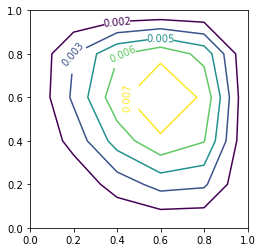

In [59]:
x = np.linspace(0,1,6)
y = np.linspace(0,1,6)
x,y = np.meshgrid(x,y)
z = psi_err.reshape(x.shape)
plt.figure()
cplot = plt.contour(x,y,z)
plt.clabel(cplot, inline=1, fontsize=10)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axes().set_aspect('equal');

In [55]:
del_psi_err = del_psit - del_psia
rmse_del_psi = np.zeros(len(xt[0]))
e2sum = np.zeros(len(xt[0]))
for j in range(len(xt[0])):
    for i in range(len(xt)):
        e2sum[j] += del_psi_err[i][j]**2
    rmse_del_psi[j] = sqrt(e2sum[j] / len(xt))

In [56]:
del2_psi_err = del2_psit - del2_psia
rmse_del_psi = np.zeros(len(xt[0]))
e2sum = np.zeros(len(xt[0]))
for j in range(len(xt[0])):
    for i in range(len(xt)):
        e2sum[j] += del_psi_err[i][j]**2
    rmse_del_psi[j] = sqrt(e2sum[j] / len(xt))

Compare the results.

In [58]:
print('    x       y      psia     psit   dpsia_dx dpsia_dy dpsit_dx dpsit_dy')
for i in range(len(psia)):
    print('%.6f %.6f %.6f %.6f %.6f %.6f %.6f %.6f' %
          (xt[i][0], xt[i][1],
           psia[i], psit[i],
           del_psia[i][0], del_psit[i][0],
           del_psia[i][1], del_psit[i][1])
        )
print('RMSE      %f          %f     %f' % 
      (rmse_psi, rmse_del_psi[0], rmse_del_psi[1]))

    x       y      psia     psit   dpsia_dx dpsia_dy dpsit_dx dpsit_dy
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
0.200000 0.000000 0.000000 0.000000 0.000000 0.000000 0.200000 0.597021
0.400000 0.000000 0.000000 0.000000 0.000000 0.000000 0.400000 1.204924
0.600000 0.000000 0.000000 0.000000 0.000000 0.000000 0.600000 1.813990
0.800000 0.000000 0.000000 0.000000 0.000000 0.000000 0.800000 2.415081
1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 3.000000
0.000000 0.200000 0.000000 0.000000 0.200000 0.196479 0.000000 0.000000
0.200000 0.200000 0.040000 0.040448 0.200000 0.206670 0.200000 0.606219
0.400000 0.200000 0.080000 0.082143 0.200000 0.209003 0.400000 1.214677
0.600000 0.200000 0.120000 0.123553 0.200000 0.203902 0.600000 1.819741
0.800000 0.200000 0.160000 0.163256 0.200000 0.192084 0.800000 2.416315
1.000000 0.200000 0.200000 0.200000 0.200000 0.174476 1.000000 3.000000
0.000000 0.400000 0.000000 0.000000 0.400000 0.403226 0.000000 0.